In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html
/kaggle/input/cifar10/cifar10.tgz
/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The label classes in the dataset are:

* airplane 
* automobile 
* bird 
* cat 
* deer 
* dog 
* frog 
* horse 
* ship 
* truck

# Import Required Libraries and Load Data from Pytorch Dataset

In [2]:
import os
import torch
import torchvision
# To read zipped .tar, .tz file
import tarfile

In [3]:
from torchvision.datasets.utils import download_url

We can download data from below given URL

In [4]:

with tarfile.open('/kaggle/input/cifar10/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path = './data')

Data is there in \data folder

In [5]:
data_dir = '/kaggle/working/data/cifar10'
print(os.listdir(data_dir))

classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test']
['frog', 'ship', 'deer', 'cat', 'horse', 'bird', 'dog', 'airplane', 'automobile', 'truck']


So, we have 10 Classes, 2 folders available Train and Test

Let's read some of Images and plot

In [6]:
airplane_file = os.listdir(data_dir + '/train/airplane')
print('Number of Training Examples: ', len(airplane_file))
print(airplane_file[:5])

Number of Training Examples:  5000
['1457.png', '1589.png', '3851.png', '2774.png', '1702.png']


In [7]:
ship_file = os.listdir(data_dir + '/test/ship')
print('Number of Testing Examples: ', len(ship_file))
print(ship_file[:5])

Number of Testing Examples:  1000
['0332.png', '0710.png', '0110.png', '0493.png', '0558.png']


In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

To reduce chance of overfitting, lets carryout Normalization and Regularization as below

In [9]:
trans = transforms.Compose([
    # this operation was done, to make Image size compatible with AlexNet Model
    transforms.Resize((70,70)),
    # To focus on only primary component of Image
    transforms.RandomCrop((64,64)),
    transforms.ToTensor(),
    # To nullify dominance of one of Color channel
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Lets load train and test data

In [10]:
train_ds = ImageFolder(data_dir+'/train', transform = trans)
val_ds = ImageFolder(data_dir+'/test', transform = trans)

In [11]:
# Below library will help us to pass batch of data, as feeding all data at once will lead to OverLoading and System will get Hang
from torch.utils.data.dataloader import DataLoader

In [12]:
# this is one of Hyper parameter, let's start with
batch_size = 512

In [13]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Plot and observe sets

In [14]:
# These libraries will help us to plot images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[: 100], 10).permute(1,2,0))
        break

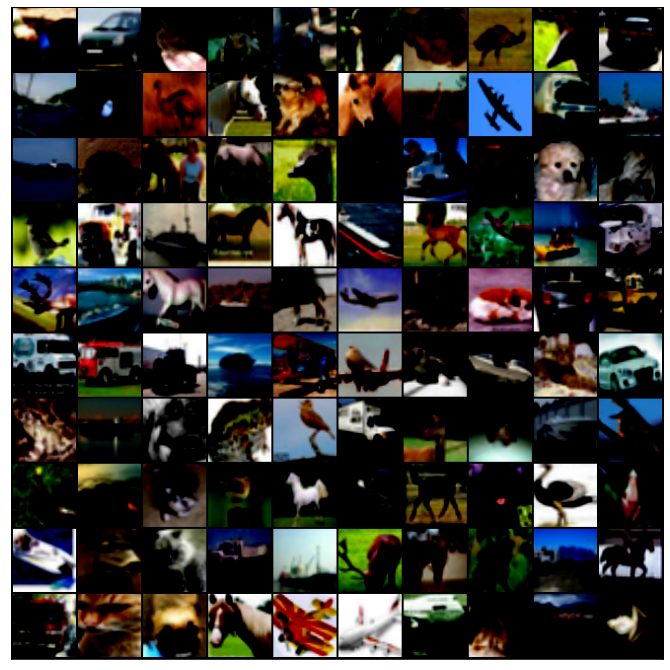

In [16]:
show_batch(train_dl)

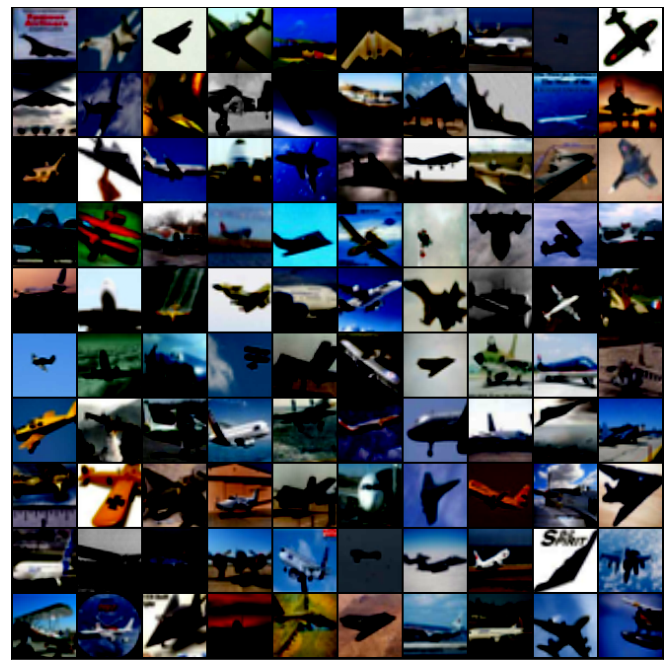

In [17]:
show_batch(valid_dl)

We can see some changes in images from original image from dataset

In [18]:
img, label = train_ds[0]
img.shape, label

(torch.Size([3, 64, 64]), 0)

# Model Building

These libraries will help us to build Neural Network

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class AlexNet(nn.Module):
    
    def __init__(self, num_classes):
        
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace = True),
            
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256*6*6)
        logit = self.classifier(x)
        
        return logit

In [21]:
# lets Initialize Model
model = AlexNet(num_classes = 10)

In [22]:
# to get all details of Model
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Let's Verify Models

In [23]:
sample = next(iter(train_ds))
img = sample[0]
img.shape

torch.Size([3, 64, 64])

In [24]:
img.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [25]:
out = model(img.unsqueeze(0))

In [26]:
F.softmax(out)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.1020, 0.0996, 0.0991, 0.1000, 0.1005, 0.1009, 0.0984, 0.0993, 0.0989,
         0.1014]], grad_fn=<SoftmaxBackward>)

In [27]:
 # Demo plot

for images, labels in train_dl:
    print('Image Shape', images.shape)
    out = model(images)
    print('output shape', out.shape)
    print('out[0]', out[0])
    break

Image Shape torch.Size([512, 3, 64, 64])
output shape torch.Size([512, 10])
out[0] tensor([ 0.0193, -0.0032, -0.0103, -0.0026,  0.0031,  0.0151, -0.0173, -0.0070,
        -0.0124,  0.0107], grad_fn=<SelectBackward>)


So, model has initial guess, it seems all options have been given same weightage i.e. 10%

In [28]:
probs = F.softmax(out[0], dim = 0)
probs

tensor([0.1020, 0.0997, 0.0990, 0.0998, 0.1003, 0.1016, 0.0983, 0.0993, 0.0988,
        0.1011], grad_fn=<SoftmaxBackward>)

In [29]:
m = torch.argmax(probs)
m

tensor(0)

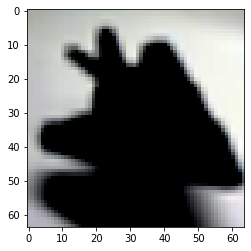

In [30]:
plt.imshow(img.permute(1,2,0))

In [31]:
sample[1]

0

So, it was wrong prediction by model, but it was just initial guess !!

# Device Selection

In [32]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Define Helper Functions

In [35]:
def loss_batch(model, loss_func, x, y, opt = None, metric = None):
    
    pred = model(x)
    
    loss = loss_func(pred, y)
    
    if opt is not None:
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    
    if metric is not None:
        
        metric_result = metric(pred, y)
        
    return loss.item(), len(x), metric_result

In [36]:
def evaluate(model, loss_fn, val_dl, metric = None):
    
    with torch.no_grad():
        
        results = [loss_batch(model, loss_fn, x, y, metric = metric) for x, y in val_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
            
    return avg_loss, total, avg_metric

In [37]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

We have defined Scheduler to handle Learning rate, as with SGD, we would be looking for Learning rate that changes based on Accuracy
If Model finds no change in Accuracy, it will reduce learning rate by factor of 0.1. Controling parameter would be validation accuracy.

In [38]:
def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = None, metric = None, scheduler = None, scheduler_on = 'val_metric'):
    
    train_losses, val_losses, val_metrics,learning_rate = [], [], [],[]
    
    
    for epoch in range(epochs):
        
        model.train()
        for x, y in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, x, y, opt_fn)
            
        model.eval()
        result = evaluate(model, loss_fn, val_dl, metric)
        val_loss, total, val_metric = result
        #print(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        learning_rate.append(get_lr(optimizer))
        if metric is None:
            print('Epoch{}/{}, train_loss: {:.4f}, val_loss: {:.4f}' 
                 .format(epoch+1, epochs, train_loss, val_loss))
            
        else:
            print('Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                 .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            
        if scheduler is not None:
            if scheduler_on == 'val_metric':
                scheduler.step(val_metrics[-1])
        
            
    return train_losses, val_losses, val_metrics,learning_rate

Function to find accuracy, as there is no built in function in Pytorh to find accuracy, its simple code to define accuracy as below

In [39]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    
    return torch.sum(preds == labels).item() / len(preds)

In [40]:
import numpy as np

Lets verify initial guess on validation

In [41]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric = accuracy)

print(val_loss, val_acc)

2.302628130722046 0.1001


# Train Model

In [42]:
num_epochs = 100

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'max', verbose = True)

In [43]:
%%time
history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, optimizer, accuracy, scheduler, 'val_metric')

Epoch 1/100, train_loss: 1.9276, val_loss: 1.9479, val_accuracy: 0.2296
Epoch 2/100, train_loss: 2.0013, val_loss: 1.8624, val_accuracy: 0.2664
Epoch 3/100, train_loss: 1.7536, val_loss: 1.6002, val_accuracy: 0.3778
Epoch 4/100, train_loss: 1.5201, val_loss: 1.4316, val_accuracy: 0.4786
Epoch 5/100, train_loss: 1.3057, val_loss: 1.3188, val_accuracy: 0.5246
Epoch 6/100, train_loss: 1.1091, val_loss: 1.1642, val_accuracy: 0.5880
Epoch 7/100, train_loss: 0.8849, val_loss: 1.0396, val_accuracy: 0.6409
Epoch 8/100, train_loss: 0.8422, val_loss: 0.9694, val_accuracy: 0.6621
Epoch 9/100, train_loss: 0.7541, val_loss: 0.8802, val_accuracy: 0.7007
Epoch 10/100, train_loss: 0.8417, val_loss: 0.8914, val_accuracy: 0.6983
Epoch 11/100, train_loss: 0.7351, val_loss: 0.8423, val_accuracy: 0.7230
Epoch 12/100, train_loss: 0.6975, val_loss: 0.8214, val_accuracy: 0.7308
Epoch 13/100, train_loss: 0.5295, val_loss: 0.8358, val_accuracy: 0.7291
Epoch 14/100, train_loss: 0.5729, val_loss: 0.8266, val_accu

In [44]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric = accuracy)

print(val_loss, val_acc)

2.255422947692871 0.7741


76% Accuracy for 10 class classification model, is not bad, adding few more dropout and batchnormalization, would have increased accuracy.


But, moto of this ntebook is not to carry out hyperparameter Tuning, it was to run this Revolutionary Model AlexNet.

# Plotting result

Plotting Train Losses

Text(0.5, 1.0, 'Plot between Training Loss vs Epochs')

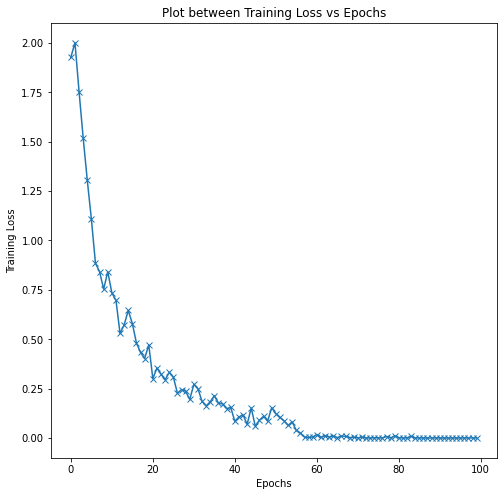

In [45]:
plt.figure(figsize = (8,8))
plt.plot(history[0], '-x')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Plot between Training Loss vs Epochs')

Text(0.5, 1.0, 'Plot between Validation Loss vs Epochs')

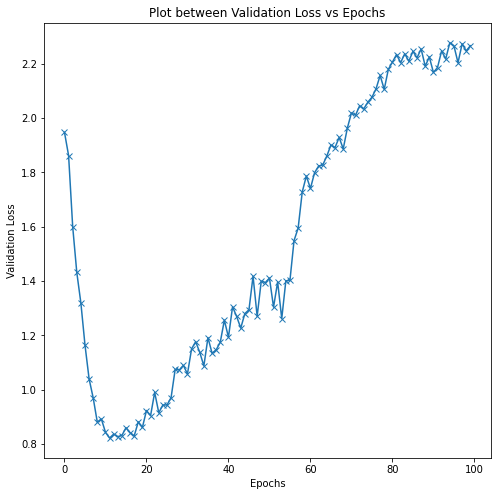

In [46]:
plt.figure(figsize = (8,8))
plt.plot(history[1], '-x')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss vs Epochs')

Seems like running few more epochs could have increased Accuracy to 80%.

But I will stop here,

Thanks for reading and I hop you have found this useful.

Kindly consider Upvoting and happy Learning!!

Text(0.5, 1.0, 'Plot between Validation Accuracy vs Epochs')

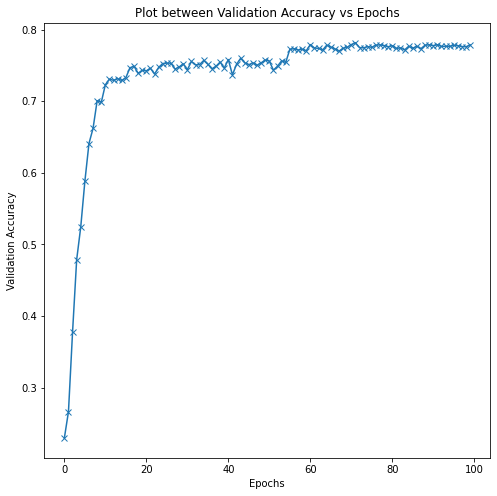

In [47]:
plt.figure(figsize = (8,8))
plt.plot(history[2], '-x')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Plot between Validation Accuracy vs Epochs')

Text(0.5, 1.0, 'Plot between Learning Rate vs Epochs')

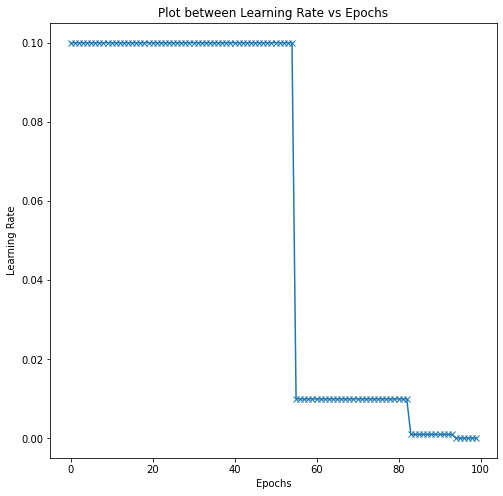

In [48]:
plt.figure(figsize = (8,8))
plt.plot(history[3], '-x')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Plot between Learning Rate vs Epochs')

In [49]:
val_ds = ImageFolder(data_dir+'/test', transform = trans)
print(val_ds.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [50]:
y_test = []
for inputs, labels in val_dl:
    y_test+=list(labels.cpu().numpy())

In [51]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in val_dl:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(y_test_pred)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list+=list(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [52]:
assert len(y_test) == len(y_pred_list)

In [53]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

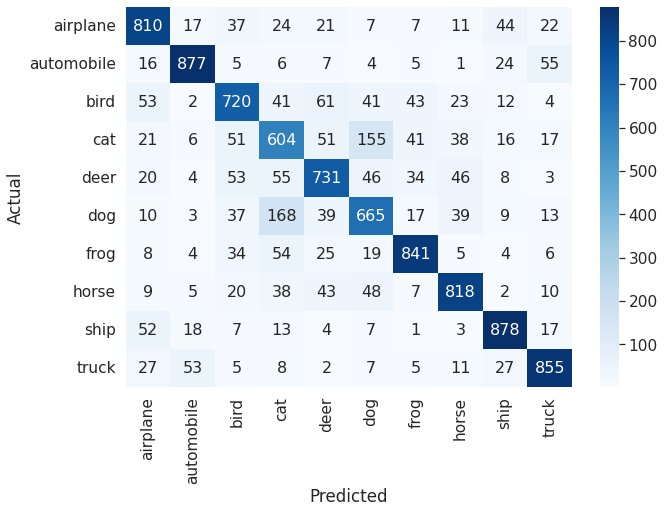

In [54]:
data = confusion_matrix(y_test, y_pred_list)
df_cm = pd.DataFrame(data, columns=list(val_ds.class_to_idx.keys()), index = list(val_ds.class_to_idx.keys()))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt="d")# font size

In [55]:
data.diagonal()/data.sum(axis=1)

array([0.81 , 0.877, 0.72 , 0.604, 0.731, 0.665, 0.841, 0.818, 0.878,
       0.855])